<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Collaborative Filtering Using a Neural Network
In this exercise we will demonstrate the use of a shallow neural network to generate predicted ratings.  We will demonstrate this on a subset of the [MovieLens](https://grouplens.org/datasets/movielens/) dataset containing 100,000 movie ratings.  In this example our dataset includes only previous ratings of movies by users - since we are not using any information about the users other than their past ratings, we must apply a collaborative filtering approach instead of content filtering.

Similar to PMF, we make the assumption that users have a set of "latent factors" which relate to their preferences for certain types of an item.  In the case of movie recommendations, these latent factors would relate to a user's preference for types of movies, e.g. which genres they like to watch - romances, comedies etc.  Likewise the items (movie, in this case) also have a set of latent factors related to their characteristics.  Possible latent factors for movies might be genres or decade produced.  

Like PMF we create an "embedding" for each user and for each item.  We can choose the dimensionality of the embeddings we create, which helps us control the complexity of the model.  These embeddings are then learned for each user and item during the training process, and they ultimately are able to represent the values of the latent factors learned.  

We then concatenate the user and item embeddings together and feed them through a shallow neural network to generate a predicted rating for each user-item pair.  A benefit of this approach relative to PMF is that we can also incorporate other information about users or movies if we have it, which can help us solve the "cold start" problem we encounter when we add a new user to the system for whom we have no prior ratings, or we add a new movie to the system which has not yet been rated by anyone.

**Notes:** 
- This should be run on GPU.  It can be run on CPU but will take ~30 minutes.

**References:**  
- Review the details on the MovieLens dataset [here](https://grouplens.org/datasets/movielens/)  

In [1]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Download the data from the GroupLens website
datapath = './data/ml-latest-small'

if not os.path.exists('./data'):
    os.makedirs('./data')
if not os.path.exists(datapath):
    url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
    urllib.request.urlretrieve(url,filename='data/ml-latest-small.zip')
    zip_ref = zipfile.ZipFile('data/ml-latest-small.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

In [3]:
# Load data
ratings = pd.read_csv(os.path.join(datapath,'ratings.csv'))
ratings = ratings.loc[:,['userId','movieId','rating']]
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


As we can see above, our dataset consists of user IDs, movie IDs of movies they have rated, and their rating for each movie.  We will now split our data into the input data (user IDs and movie IDs) and the target we are trying to predict (the ratings).  We will then split our data to create a validation set.

In [4]:
X = ratings.loc[:,['userId','movieId']]
y = ratings.loc[:,'rating']

# Split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

We can now put our data into PyTorch DataLoaders as we have done before with tabular data.

In [5]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

## Define model architecture
We will create our own architecture for our NN-based recommendation system.  It should include embeddings for the users and items of a specified dimensionality.  However, unlike PMF where we took the dot product of a user embedding and an item embedding to get the predicted rating, we will now instead concatenate the user embedding and item embedding together.  We then pass the concatenated embedding for the user-item pair through two linear layers with a ReLu activation in between.  The output from the second linear layer is our prediction.  We commonly use a sigmoid function and scale the range of predictions to constrain it within our expected range (e.g. 0 to 5 stars).

In [6]:
class NNColabFiltering(nn.Module):
    
    def __init__(self, n_users, n_items, embedding_dim_users, embedding_dim_items, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embedding_dim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embedding_dim_items)
        self.fc1 = nn.Linear(embedding_dim_users+embedding_dim_items,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_items = self.item_embeddings(X[:,1])
        # Concatenate user and item embeddings
        embeddings = torch.cat([embedded_users,embedded_items],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds
        


In [7]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the input images and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [8]:
dataloaders = {'train':trainloader, 'val':valloader}

n_users = X.loc[:,'userId'].max()+1
n_items = X.loc[:,'movieId'].max()+1
model = NNColabFiltering(n_users,n_items,embedding_dim_users=50, embedding_dim_items=50, n_activations = 100,rating_range=[0.,5.])

criterion = nn.MSELoss()
lr=0.001
n_epochs=10
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)


Epoch 0/9
----------
train loss: 0.9763
val loss: 0.9555
Epoch 1/9
----------
train loss: 0.9182
val loss: 0.9086
Epoch 2/9
----------
train loss: 0.8772
val loss: 0.8826
Epoch 3/9
----------
train loss: 0.8532
val loss: 0.8705
Epoch 4/9
----------
train loss: 0.8387
val loss: 0.8670
Epoch 5/9
----------
train loss: 0.8276
val loss: 0.8639
Epoch 6/9
----------
train loss: 0.8205
val loss: 0.8611
Epoch 7/9
----------
train loss: 0.8136
val loss: 0.8611
Epoch 8/9
----------
train loss: 0.8088
val loss: 0.8589
Epoch 9/9
----------
train loss: 0.8026
val loss: 0.8589
Training complete in 0m 45s


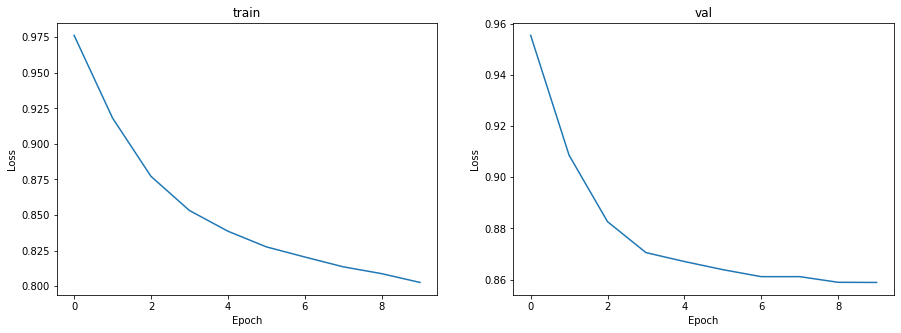

In [9]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

## Get predicted rating for a user-movie pair
Now that our model is trained we can use it to generate predicted ratings of a given user for a given movie.  To do so we simply feed a user-item pair into our model and get the predicted rating.  We could also do other things such as determine which movie (out of all movies in our set) a particular user might rate the highest, and recommend that to him/her.

In [10]:
def predict_rating(model,userId,movieId, device):
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        X = torch.Tensor([userId,movieId]).long().view(1,-1)
        X = X.to(device)
        pred = model.forward(X)
        return pred

rating = predict_rating(model,5,10,device)
print('Predicted rating is {:.1f}'.format(rating.detach().cpu().item()))

Predicted rating is 3.5


## Generate recommendations for user
Now that we have a trained model, we can use our model not only to predict a user's rating for a movie they have not seen but also to generate recommended movies for a user to watch.  The approach we will use to generate recommendations is as follows:  
- Use our model to predict the rating a user will assign to every movie in the set
- Sort the movies by predicted rating
- Remove movies the user has already seen
- Return the top predictions as the recommendations to watch

In [11]:
def generate_recommendations(movies,X,model,userId,device):
    # Get predicted ratings for every movie
    pred_ratings = []
    for movie in movies['movieId'].tolist():
        pred = predict_rating(model,userId,movie,device)
        pred_ratings.append(pred.detach().cpu().item())
    # Sort movies by predicted rating
    idxs = np.argsort(np.array(pred_ratings))[::-1]
    recs = movies.iloc[idxs]['movieId'].values.tolist()
    # Filter out movies already watched by user
    movies_watched = X.loc[X['userId']==userId, 'movieId'].tolist()
    recs = [rec for rec in recs if not rec in movies_watched]
    # Filter to top 10 recommendations
    recs = recs[:10]
    # Convert movieIDs to titles
    recs_names = []
    for rec in recs:
        recs_names.append(movies.loc[movies['movieId']==rec,'title'].values[0])
    return recs_names


In [12]:
userId = 5
movies = pd.read_csv(os.path.join(datapath,'movies.csv'))
recs = generate_recommendations(movies,X,model,userId,device)
for i,rec in enumerate(recs):
  print('Recommendation {}: {}'.format(i,rec))

Recommendation 0: Guess Who's Coming to Dinner (1967)
Recommendation 1: Three Billboards Outside Ebbing, Missouri (2017)
Recommendation 2: Casablanca (1942)
Recommendation 3: His Girl Friday (1940)
Recommendation 4: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Recommendation 5: Star Wars: Episode V - The Empire Strikes Back (1980)
Recommendation 6: Boondock Saints, The (2000)
Recommendation 7: Princess Bride, The (1987)
Recommendation 8: American History X (1998)
Recommendation 9: Fight Club (1999)
